In [4]:
NAME = "Frederik Hardervig"


# CS110 Fall 2019 - Final Project
# Plate Cutting


## Overview

# Assignment Questions

Each of the questions below will be graded on the CS110 LOs included inside square brackets: 

## Part A [#responsibility] [appropriate LO for the make-up work] 



In [5]:
from IPython.display import Image

As for data structures, we will need a convenient way to store information about the sheet that we're populating and the shapes which we will populate it with. As such, we will create a class for the sheet which will hold the matrix of free slots as a nested list, the current profit of the sheet, the diagram visualizing the sheet, and counters for how many of each shape is on the sheet. Additionally, we will create a class for the shapes which will hold not only the list of relative coordinates defining the shape and its value, but also a set of methods that allows us to test out the different possible configurations. These will include rotation, mirroring, and a function to return a list of the configurations. To optimize a bit, we will include attributes such as symmetry to test whether we will need to mirror when creating our rotated configurations, see figure \ref{fig:box} for an example of when mirroring would be a waste of computations. Lastly, we will include some somewhat attributes such as color and line thickness for when we draw the shapes onto the sheet.

In [6]:
import random as ran
import copy

#Converts a grid position into a pixel coordinate. Top left in the grid may be [0,0],
#but the actual pixel coordinate will be the middle of that square.
def pixelPos(x,y, gridsize):
    return (x*gridsize+gridsize//2, y*gridsize+gridsize//2)

#Our shape class holds a given shape that is defined by a list of coordinates.
#It includes helpful functions to draw it, hold colors to disginguish different shapes,
#and a value attribute that we wish to maximize on our final plate
class Shape:
    """ 
    This class implements properties and methods that support a max priority queue data structure
    """  
    def __init__(self, name, grid, value, RGBcolor, loop = False, symmetric = True, thickness = 15, width = 0.7):  
        #self.grid is a list of coordinates the shape fills including origin [0,0].
        #be mindful that the ordering here, determines the order the lines are drawn in when shown.
        self.name       = name
        self.grid       = grid      
        self.value      = value     #Determine value of shape
        self.color      = RGBcolor  #RGB tuple determining color of drawn shape
        self.thickness  = thickness #Sets the thickness of drawn lines
        self.loop       = loop      #Determine if drawn lines loops back
        self.blockwidth = width/2   #Sets the width of drawn blocks
        self.symmetric  = symmetric
        self.configs    = self.gen_configs()
        
    
    #Rotates 90 degrees clockwise.
    '''BE CAREFUL. ROTATING THE SHAPE WILL ROTATE ALL PIECES OF THE SHAPE'''
    def rotate(self, amount=1): #Amount can be changed, e.g. amount=2 gives 180 degrees
        for _ in range(amount%4): #Modulus to avoid unnecessary loops for e.g. amount = 8.
            self.grid = [[-block[1],block[0]] for block in self.grid]
    
    #Mirrors the shape around an axis. 0 for horizontal, 1 for vertical
    def mirror(self, axis = 0):
        if axis == 0:
            self.grid = [[block[0],-block[1]] for block in self.grid] #Flip y-coordinates
        else:
            self.grid = [[-block[0],block[1]] for block in self.grid] #Flip x-coordinates
    
    def gen_configs(self):
        configlst = []
        #We do the full rotation so that it ends up making no change
        for i in range(4):
            self.rotate() #Do a rotation
            configlst.append([cell for cell in self.grid]) #Save the grid in the list
        if self.symmetric == False: #If figure isn't symmetric, create rotations of the mirrored
            self.mirror() #Mirror around horizontal axis
            for i in range(4): #Perform all four 90 degree rotations again and store their grid
                self.rotate()
                configlst.append([cell for cell in self.grid])
            self.mirror() #Revert the mirroring
        return configlst
        

#Our Piece class let's us create pieces of given shapes and lay onto our plate.
#Counting the combined value of the pieces in the end will let us maximize profit.
class Piece:
    """ 
    This class implements properties and methods that support a max priority queue data structure
    """  
    def __init__(self, pieceshape, x, y, grid = None):  
        self.shape      = copy.deepcopy(pieceshape)
        if grid == None:
            self.grid   = copy.deepcopy(pieceshape.grid) #Each piece inherits most attributes from a shape
        else:
            self.grid   = grid
        self.x          = x          #
        self.y          = y

    def move(self, x, y):
        self.x += x
        self.y += y
        
    def set_pos(self, x, y):
        self.x = x
        self.y = y
        
    def jiggle(self, power = 1):
        self.move(ran.randint(-power, power),ran.randint(-power, power))
    
    #Draws the shape to a given image
    def drawPiece(self, draw, blocksize):
        #Set the initial position
        #position must've been converted to pixels, use pixelPos(x,y)
        startpos = pixelPos(self.x,self.y,blocksize)
        pos = pixelPos(self.x,self.y,blocksize)
        
        #For every block in the shape
        for block in self.grid:
            #Draw a line from the current block to the next.
            #First determine coordinates, then draw.
            line = (pos, (startpos[0]+blocksize*block[0],startpos[1]+blocksize*block[1]))
            draw.line(line, fill=self.shape.color, width = self.shape.thickness)
            
            #Draw a square over the current position.
            #First obtain coordinates to two opposite corners of the square
            #Then draw it.
            
            #Top left corner coordinate
            box = ((startpos[0]+blocksize*block[0]-int(blocksize*self.shape.blockwidth),
                    startpos[1]+blocksize*block[1]-int(blocksize*self.shape.blockwidth))
                   #Bottom right corner coordinate
                   ,(startpos[0]+blocksize*block[0]+int(blocksize*self.shape.blockwidth),
                     startpos[1]+blocksize*block[1]+int(blocksize*self.shape.blockwidth)))
            draw.rectangle(box, fill=self.shape.color)
            
            #Update position to next block in the shape
            pos = (startpos[0]+blocksize*block[0],startpos[1]+blocksize*block[1]) 
            
        #If we wish to loop our line back to origin then draw a line as above.
        if self.shape.loop == True: 
            line = (pos, (startpos[0]+blocksize*self.grid[0][0],startpos[1]+blocksize*self.grid[0][1]))
            draw.line(line, fill=self.shape.color, width = self.shape.thickness)

#Our shape class holds a given shape that is defined by a list of coordinates.
#It includes helpful functions to draw it, hold colors to disginguish different shapes,
#and a value attribute that we wish to maximize on our final plate
class Sheet:
    """ 
    This class implements properties and methods that support a max priority queue data structure
    """  
    def __init__(self, gridx, gridy, gridsize, bgColor = (255,255,255), horColor = (128,128,128), vertColor = (128,128,128)):  
        #self.grid is a list of coordinates the shape fills including origin [0,0].
        #be mindful that the ordering here, determines the order the lines are drawn in when shown.
        self.shape           = (gridx,gridy)
        self.gridT          = [[False for _ in range(self.shape[0])] for _ in range(self.shape[1])]
        self.img, self.draw  = self.create_grid(self.shape[0], self.shape[1], 
                                                gridsize, bgColor, horColor, vertColor)
        self.profit          = 0     #Determine value of shape
        
    def create_grid(self, x_boxes, y_boxes, box_size, bgColor, horColor, vertColor):
        image = Image.new(mode='RGB', size=(box_size*x_boxes, box_size*y_boxes), color=bgColor)

        # Draw a grid
        imgdraw = ImageDraw.Draw(image)

        x_start, y_start = 0, 0
        x_end, y_end     = image.width, image.height

        for x in range(box_size, image.width, box_size):
            line = ((x, y_start), (x, y_end))
            imgdraw.line(line, fill=horColor)

        for y in range(box_size, image.height, box_size):
            line = ((x_start, y), (x_end, y))
            imgdraw.line(line, fill=vertColor)

        return image, imgdraw

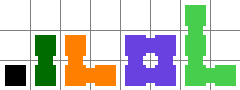

In [8]:
from PIL import Image, ImageDraw
from IPython.display import display

gridsize = 30
gridx = 8
gridy = 3

oneOneSquare = Shape('oos',[[0,0]], 0.1, (0,0,0))
oneTwo = Shape('ots',[[0,0],[0,1]], 2, (0,108,0))
smallCorner = Shape('sc',[[1,0],[0,0],[0,-1]],3.5,(255, 128, 0))
twoTwoSquare = Shape('tts',[[0,0],[1,0],[1,-1],[0,-1]],5,(105, 65, 225), loop = True)
LShape = Shape('ls',[[1,0],[0,0],[0,-1],[0,-2]],6,(71, 206, 76), symmetric= False)


single = Piece(oneOneSquare, 0,2)
double = Piece(oneTwo, 1,1)
corner = Piece(smallCorner, 2,2)
square = Piece(twoTwoSquare, 4,2)
letter = Piece(LShape, 6,2)


sheet = Sheet(gridx, gridy, gridsize)

pieces = [single, double, corner, square, letter]

for piece in pieces:
    piece.drawPiece(sheet.draw,gridsize)

display(sheet.img)
pic = sheet.img.save("Hello.jpg")

`create_grid()` inspired by https://randomgeekery.org/2017/11/24/drawing-grids-with-python-and-pillow/

Profit 53.2


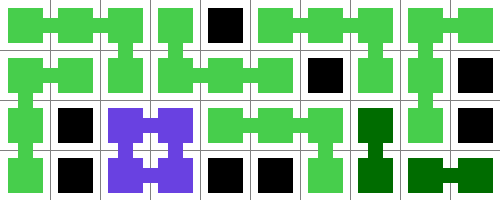

In [19]:
def packgrid(shapes, gridsize, gridx, gridy, package = None, start_row = 0, start_column = 0, start_shape = 0):
    sheet = Sheet(gridx,gridy,gridsize)
    
    for shape in shapes[start_shape:]:
        for row in range(start_row, len(sheet.gridT)):
            start_row = 0 #Reset for the next shape
            for column in range(start_column, len(sheet.gridT[row])):
                start_column = 0 #Reset for the next row
                shape.rotate(ran.randint(0,3))
                if sheet.gridT[row][column] == True:
                    continue
                else:
                    check = True
                    for cell in shape.grid:
                        try:
                            if sheet.gridT[row+cell[1]][column+cell[0]] == False\
                            and row+cell[1]>=0\
                            and column+cell[0]>=0:
                                continue
                            else:
                                check = False
                                break
                        except IndexError:
                            check = False
                            break
                            
                    if check == True:
                        sheet.profit += shape.value
                        for change in shape.grid:
                            sheet.gridT[row+change[1]][column+change[0]] = True
                        Piece(shape, column, row).drawPiece(sheet.draw,gridsize)
                        
                #packgrid(shapes, gridsize, gridx, gridy, start_row = 0, start_column = 2, start_shape = 2)
    return sheet.profit, sheet.img

gridsize = 50
gridx = 10
gridy =4

oneOneSquare = Shape('oos',[[0,0]], 1, (0,0,0))
oneTwo = Shape('ots',[[0,0],[1,0]], 2.1, (0,108,0))
twoTwoSquare = Shape('tts',[[0,0],[1,0],[1,1],[0,1]],5,(105, 65, 225), loop = True)
smallCorner = Shape('sc',[[1,0],[0,0],[0,1]],3.5,(255, 128, 0))
LShape = Shape('ls',[[-1,0],[0,0],[1,0],[1,1]],6,(71, 206, 76), symmetric= False)

shapes = [LShape, twoTwoSquare, smallCorner, oneTwo, oneOneSquare]

p, i = packgrid(shapes, gridsize, gridx, gridy)
print("Profit", p)
display(i)

In [20]:
def packgrid_randomfit(shapes, gridsize, gridx, gridy, start_row = 0, start_column = 0, start_shape = 0):
    sheet = Sheet(gridx,gridy,gridsize)
    
    for shape in shapes[start_shape:]:
        for row in range(start_row, len(sheet.gridT)):
            start_row = 0 #Reset for the next shape
            for column in range(start_column, len(sheet.gridT[row])):
                start_column = 0 #Reset for the next row
                solutions = []
                for config in shape.configs:
                    if sheet.gridT[row][column] == True:
                        continue
                    else:
                        check = True
                        for cell in config:
                            try:
                                if sheet.gridT[row+cell[1]][column+cell[0]] == False\
                                and row+cell[1]>=0\
                                and column+cell[0]>=0:
                                    continue
                                else:
                                    check = False
                                    break
                            except IndexError:
                                check = False
                                break
                
                        if check == True:
                            solutions.append(config)
                if len(solutions) > 0:
                    sheet.profit += shape.value
                    sol = ran.randint(0,len(solutions)-1)
                    for change in solutions[sol]:
                        sheet.gridT[row+change[1]][column+change[0]] = True
                    Piece(shape, column, row, grid = solutions[sol]).drawPiece(sheet.draw,gridsize)
                        
                #packgrid(shapes, gridsize, gridx, gridy, start_row = 0, start_column = 2, start_shape = 2)
    return sheet.profit, sheet.img

In [61]:
def run_randpack(gridx, gridy, gridsize, reps, printing = False, saving = False):
    oneOneSquare = Shape('oos',[[0,0]], 0.1, (0,0,0))
    oneTwo = Shape('ot',[[0,0],[1,0]], 2, (0,108,0))
    twoTwoSquare = Shape('tts',[[0,0],[1,0],[1,1],[0,1]],5,(105, 65, 225), loop = True)
    smallCorner = Shape('sc',[[1,0],[0,0],[0,1]],3.5,(255, 128, 0))
    LShape = Shape('ls',[[-1,0],[0,0],[1,0],[1,1]],6,(71, 206, 76), symmetric= False)

    shapes = [LShape, twoTwoSquare, smallCorner, oneTwo, oneOneSquare]

    best = (0,0)
    for i in range(reps):
        profit, img = packgrid(shapes, gridsize, gridx, gridy)
        if profit > best[0]:
            best = (profit, img)
    if saving == True:
        saved = best[1].save("A"+str(gridx)+"X"+str(gridy)+"trueran"+str(best[0])+".jpg")
    if printing == True:
        print("Profit",best[0])
        display(best[1])
    
def run_packing(gridx, gridy, gridsize, reps, printing = False, saving = False):
    '''ONE SQUARE VALUE 0'''
    oneOneSquare = Shape('oos',[[0,0]], 0.1, (0,0,0))
    oneTwo = Shape('ot',[[0,0],[1,0]], 2, (0,108,0))
    twoTwoSquare = Shape('tts',[[0,0],[1,0],[1,1],[0,1]],5,(105, 65, 225), loop = True)
    smallCorner = Shape('sc',[[1,0],[0,0],[0,1]],3.5,(255, 128, 0))
    LShape = Shape('ls',[[-1,0],[0,0],[1,0],[1,1]],6,(71, 206, 76), symmetric= False)

    shapes = [LShape, twoTwoSquare, smallCorner, oneTwo, oneOneSquare]

    best = (-1,-1)
    rounds, remainder = divmod(gridx*gridy, 4)
    optimal = rounds*6
    if remainder == 0:
        pass
    elif remainder == 1:
        optimal += 1
    elif remainder == 2:
        optimal += 2.1
    elif remainder == 3:
        optimal += 3.5
    for i in range(reps):
        profit, img = packgrid_randomfit(shapes, gridsize, gridx, gridy, start_shape = 0)
        if profit > best[0]:
            best = (profit, img)
            #If approximately optimal solution has been found
            #no need to run more trials
            #if profit > optimal*0.95:
            #    break
    if saving == True:
        saved = best[1].save("A"+str(gridx)+"X"+str(gridy)+"ranfit"+str(best[0])+".jpg")
    if printing == True:
        print("Profit",best[0])
        display(best[1])

Entering iteration  1
Profit 5128.00000000006


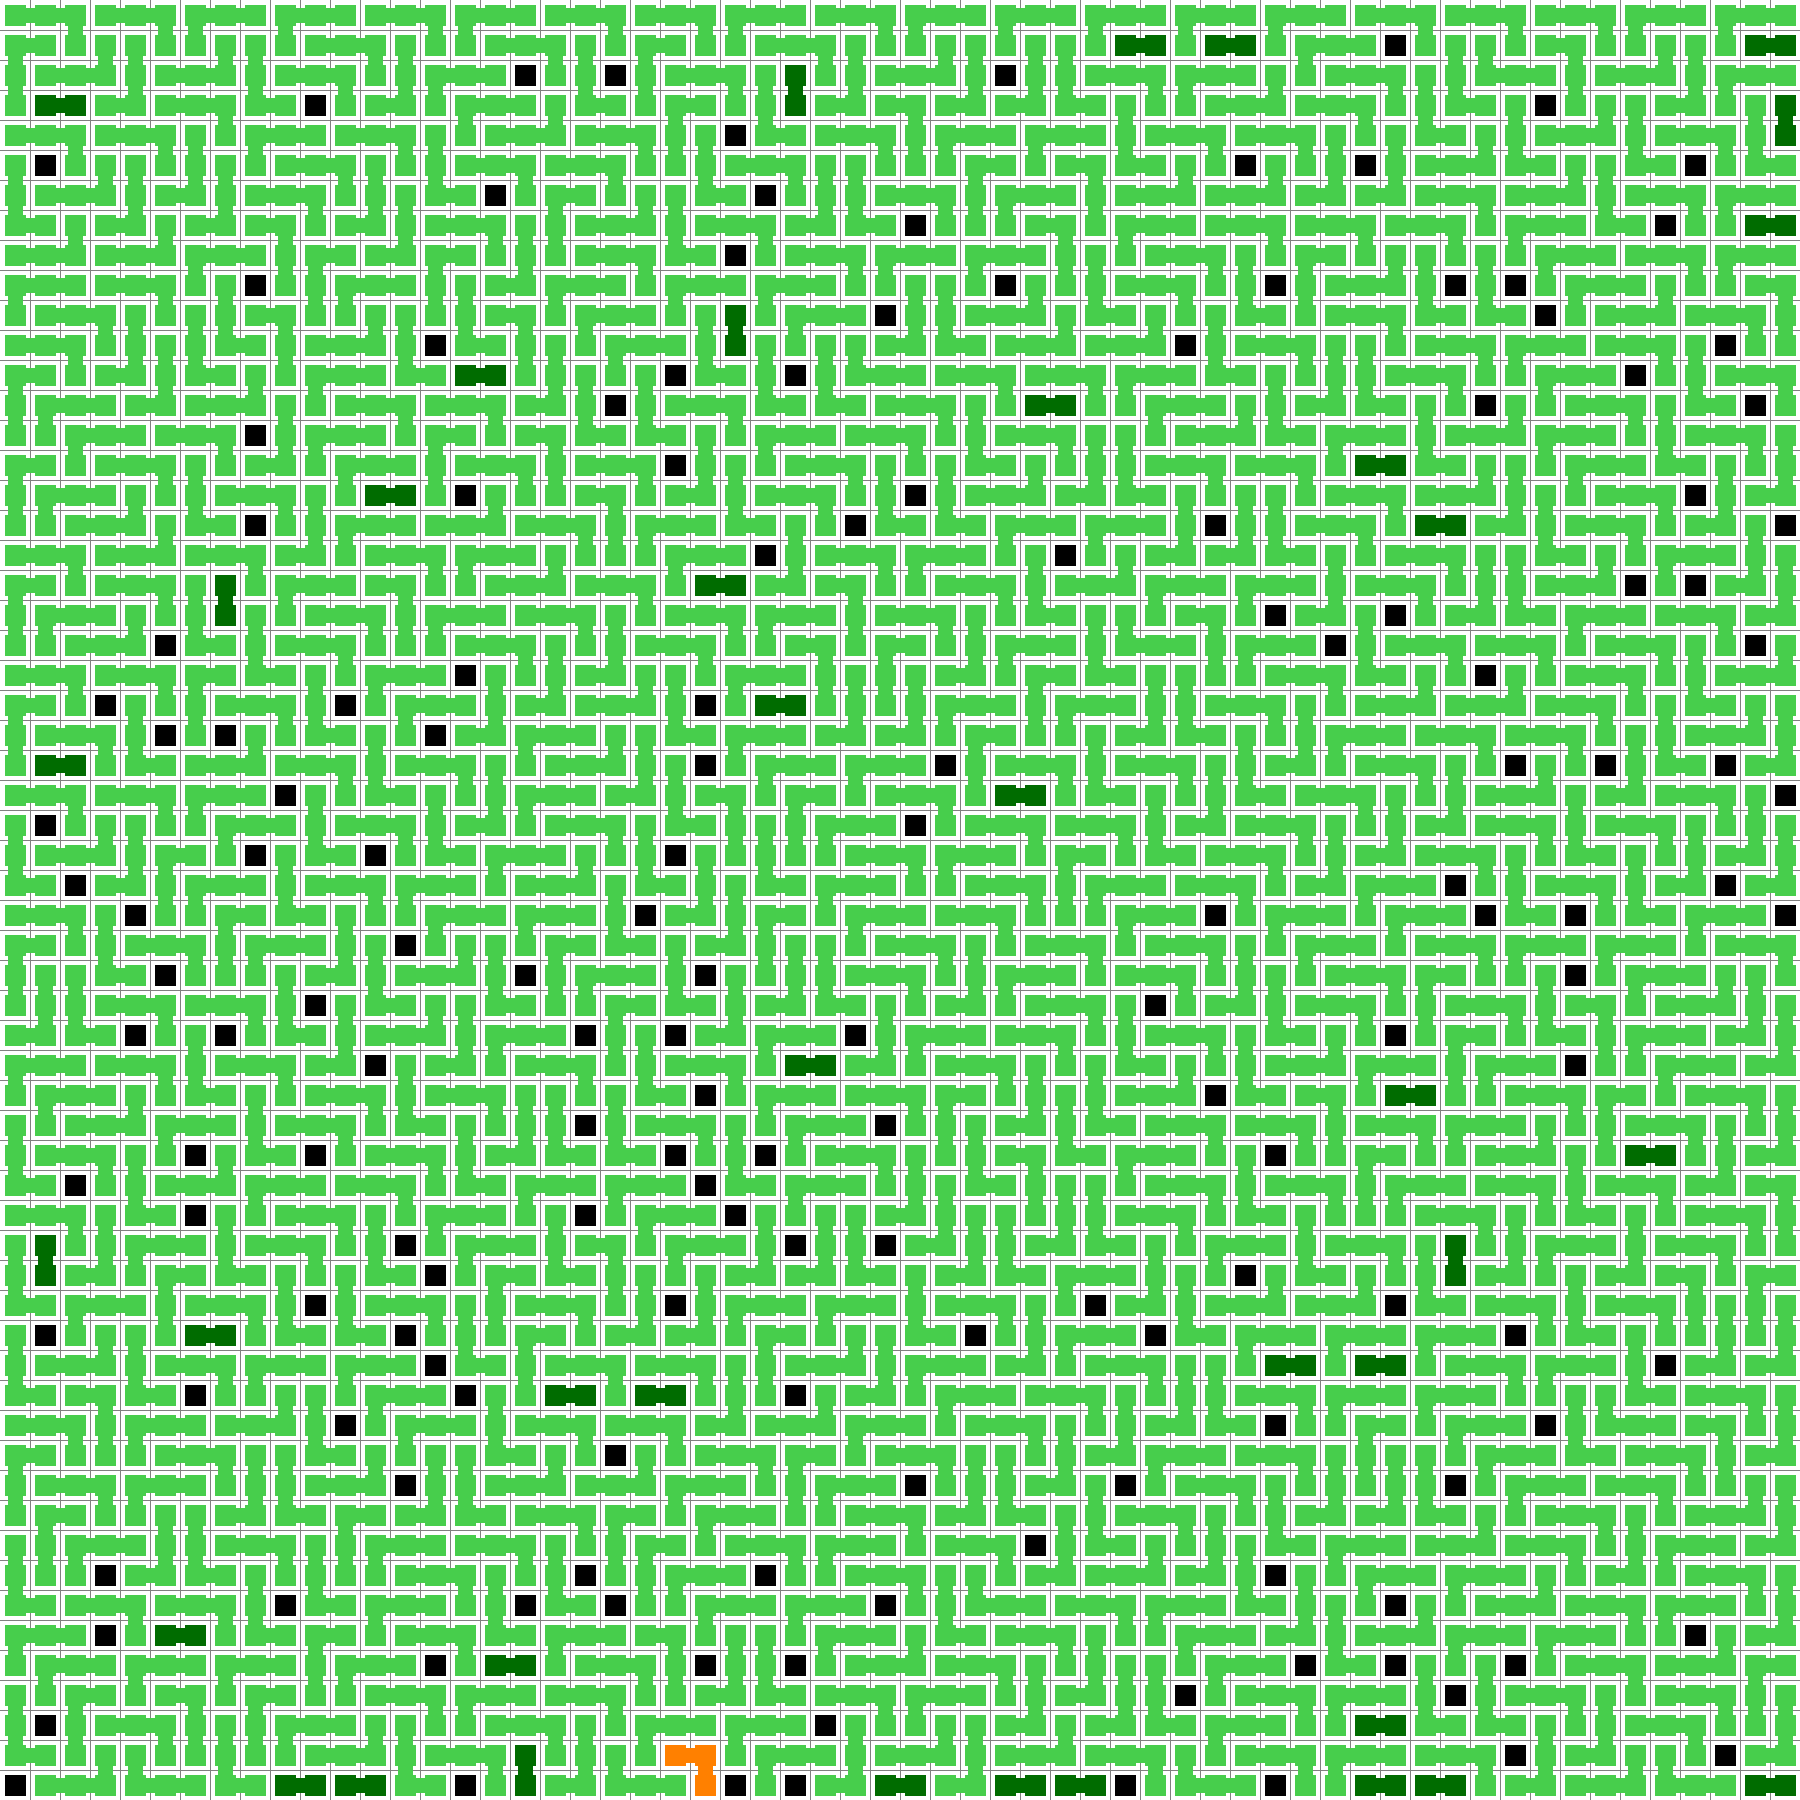

19.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Profit 4622.000000000158


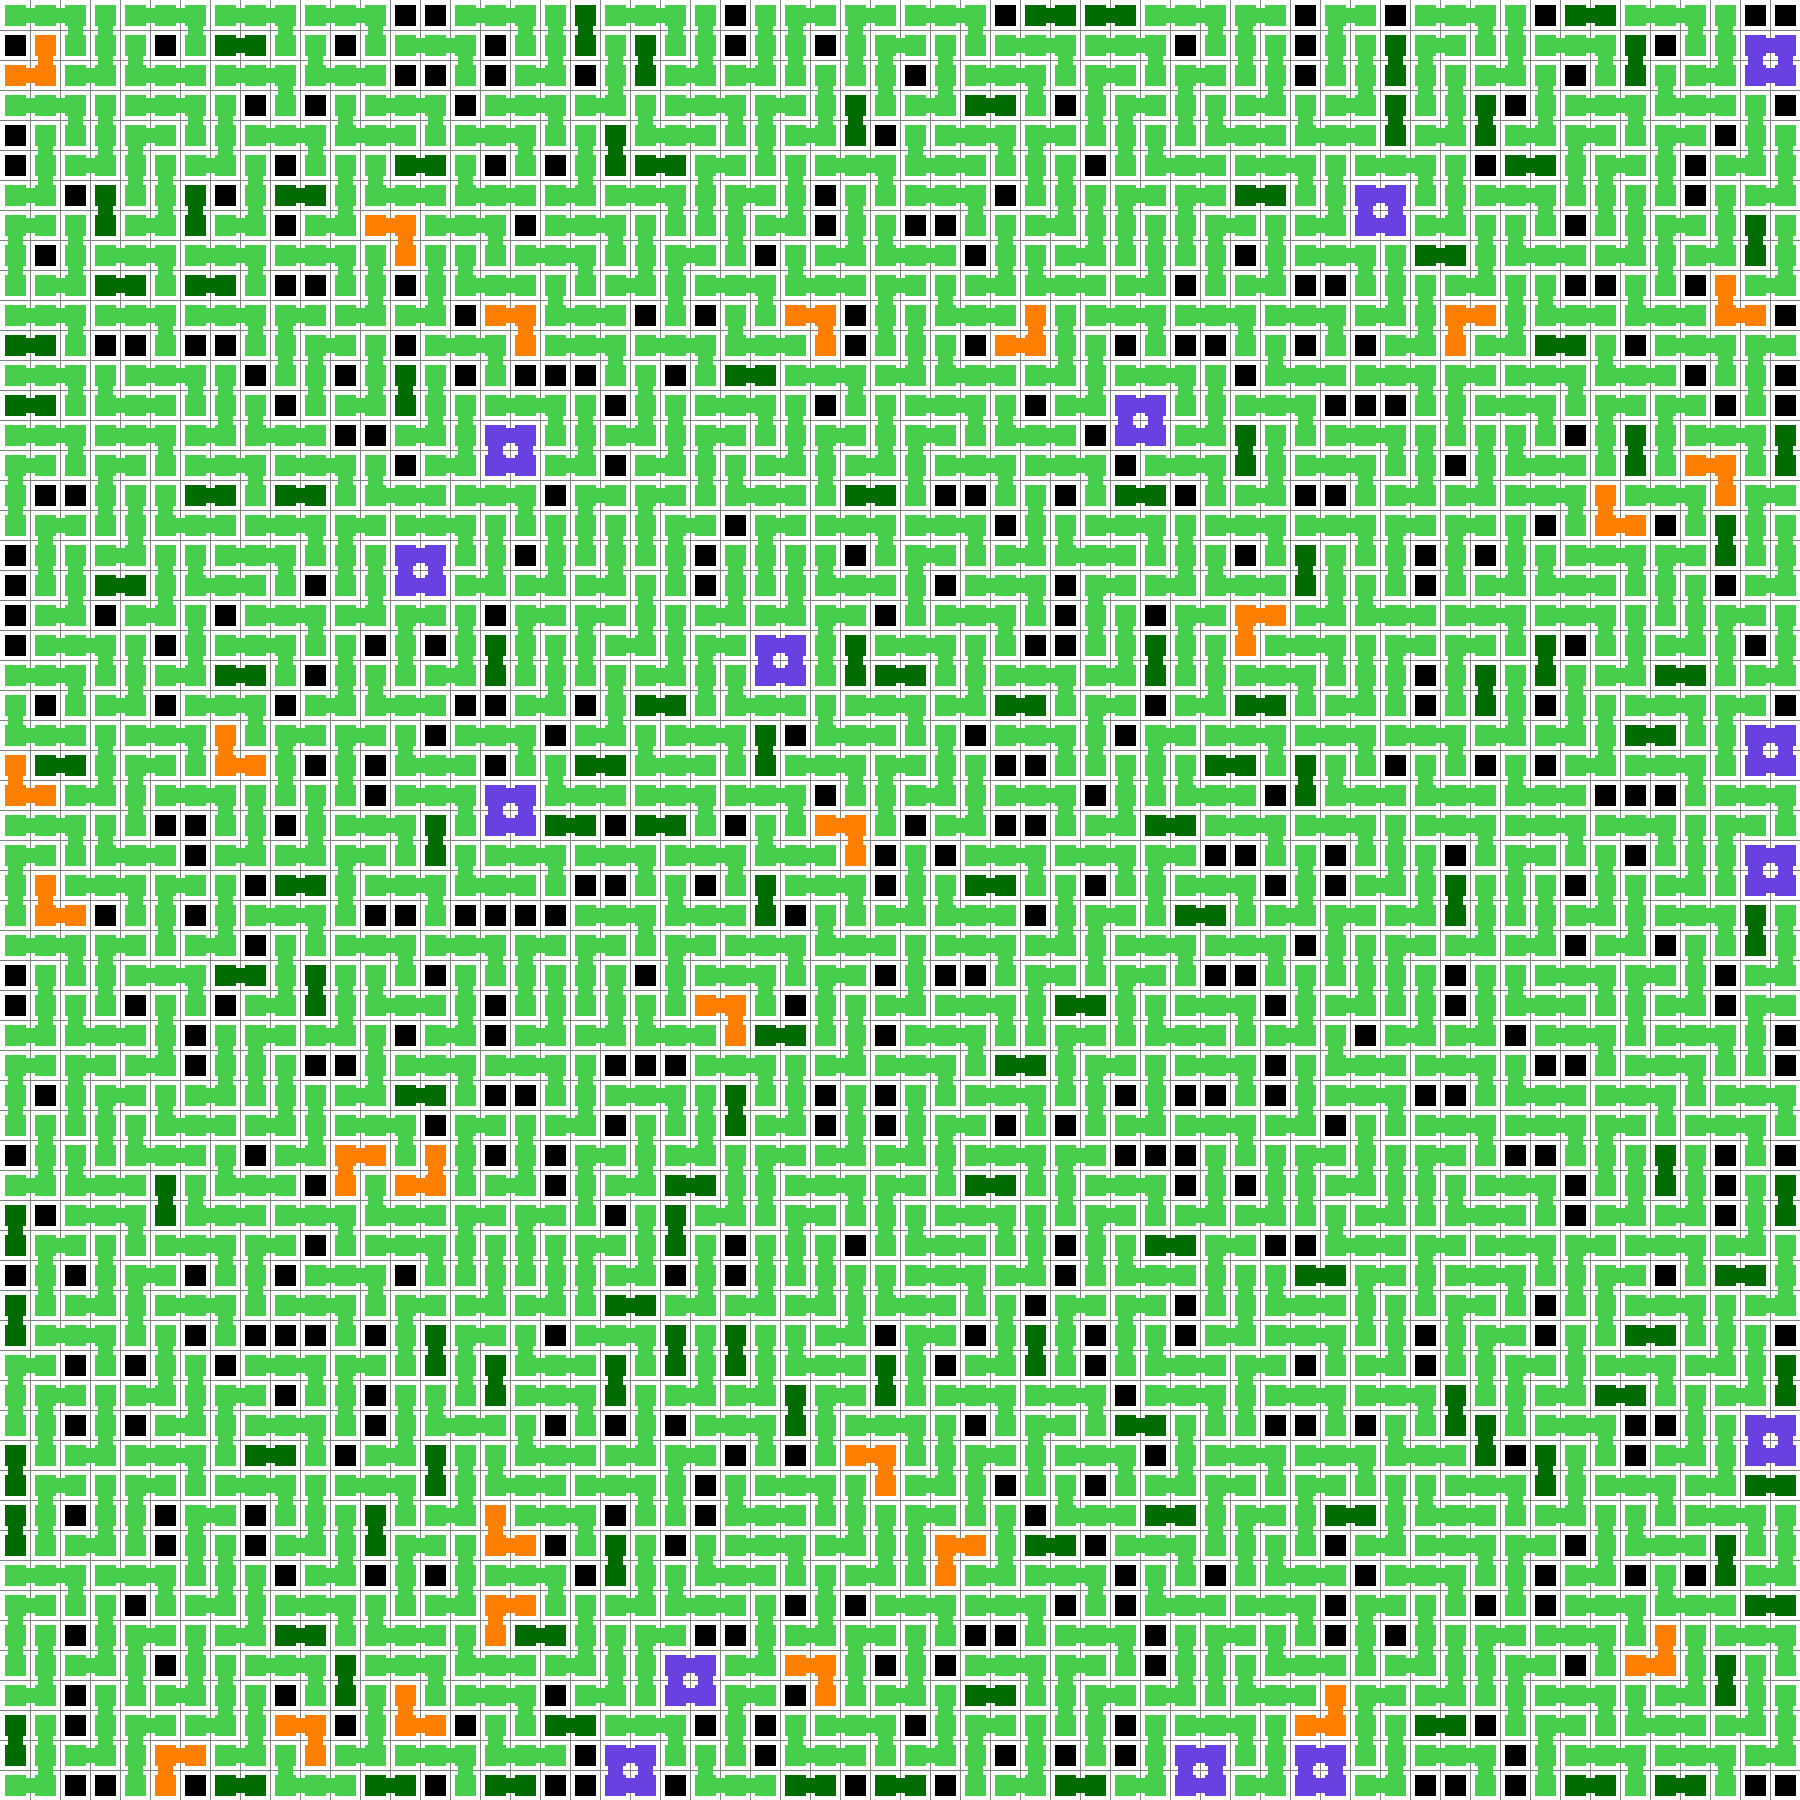

24.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


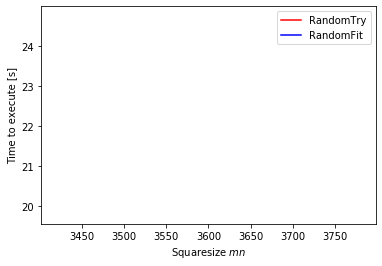

Wall time: 44.9 s


In [68]:
%%time
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

gridsize = 30
maxgridx = 61#50
maxgridy = 61#50
reps     = 100 
iters    = 1#10
step     = 5

resultlst = []
ranresultlst = []
for iteration in range(iters):
    print("Entering iteration ", iteration+1)
    results = []
    ranresults = []
    xlst = []
    for i in range(60,maxgridx, step):
        xlst.append(i**2)
        result = %timeit -n1 -r1 -o run_packing(i,i,gridsize,reps, printing = True, saving = True)
        results.append(result)
        ranresult = %timeit -n1 -r1 -o run_randpack(i,i,gridsize,reps, printing = True, saving = True)
        ranresults.append(ranresult)
        '''
        for j in range(1,maxgridy, step):
            xlst.append(i*j)
            result = %timeit -n1 -r1 -o run_packing(i,j,gridsize,reps, printing = True, saving = True)
            results.append(result)
            ranresult = %timeit -n1 -r1 -o run_randpack(i,j,gridsize,reps, printing = True,saving = True)
            ranresults.append(ranresult)
        '''
    

    avglst = []
    ranavglst = []
    for res in results:
        avglst.append(res.average)
    resultlst.append(avglst)
    
    for ranres in ranresults:
        ranavglst.append(ranres.average)
    ranresultlst.append(ranavglst)

ranavgresult = np.average(np.asarray(ranresultlst), axis=0)
avgresult = np.average(np.asarray(resultlst), axis=0)

#Plot the runtimes.
plt.plot(xlst, ranavgresult, color='Red', label = 'RandomTry')
plt.plot(xlst, avgresult, color='Blue', label = 'RandomFit')
plt.xlabel('Squaresize $mn$')
plt.ylabel('Time to execute [s]')
plt.legend()
plt.savefig('RuntimeGrid'+str(maxgridx)+'Reps'+str(reps)+'.png',bbox_inches='tight')
plt.show()

In [38]:
#Experimental function inspired by physics engines in games, which turned out to be very inaccurate. 
#Essentially, we introduce more uncertainty by ending up trying to 
#fit into neighbouring cells rather than the next in line. 
def packgrid_jigglefit(shapes, gridsize, gridx, gridy, power, jigprob):
    sheet = Sheet(gridx, gridy, gridsize)
    
    for shape in shapes:
        for row in range(len(sheet.gridT)):
            for column in range(len(sheet.gridT[row])):
                solutions = []
                jigx, jigy = (ran.random(),ran.random())
                if jigx > 1-(jigprob/2):
                    row += power
                elif jigx > jigprob/2:
                    row += -power
                
                if jigy > 1-(jigprob/2):
                    column += power
                elif jigy > jigprob/2:
                    column += -power
                for config in shape.configs:
                    if row < 0 or column < 0 or row >= len(sheet.gridT):
                        continue
                    elif column >= len(sheet.gridT[row]):
                        continue
                    elif sheet.gridT[row][column] == True:
                        continue
                    else:
                        check = True
                        for cell in config:
                            try:
                                if sheet.gridT[row+cell[1]][column+cell[0]] == False\
                                and row+cell[1]>=0\
                                and column+cell[0]>=0:
                                    continue
                                else:
                                    check = False
                                    break
                            except IndexError:
                                check = False
                                break
                            else:
                                print("Something is wrong")
                
                        if check == True:
                            solutions.append(config)
                if len(solutions) > 0:
                    sheet.profit += shape.value
                    sol = ran.randint(0,len(solutions)-1)
                    for change in solutions[sol]:
                        sheet.gridT[row+change[1]][column+change[0]] = True
                    Piece(shape, column, row, grid = solutions[sol]).drawPiece(sheet.draw,gridsize)
                
                if jigx > 1-(jigprob/2):
                    row += -power
                elif jigx > jigprob/2:
                    row += power
                
                if jigy > 1-(jigprob/2):
                    column += -power
                elif jigy > jigprob/2:
                    column += power
                    
                #packgrid(shapes, gridsize, gridx, gridy, start_row = 0, start_column = 2, start_shape = 2)
    return sheet.profit, sheet.img


Profit 35.2


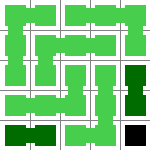

In [24]:
gridsize = 30
gridx    = 5
gridy    = 5
reps     = 10
iters    = 10
step     = 5
power    = 1
jigprob  = 0.2

oneOneSquare = Shape('oos',[[0,0]], 1, (0,0,0))
oneTwo = Shape('ot',[[0,0],[1,0]], 2.1, (0,108,0))
twoTwoSquare = Shape('tts',[[0,0],[1,0],[1,1],[0,1]],5,(105, 65, 225), loop = True)
smallCorner = Shape('sc',[[1,0],[0,0],[0,1]],3.5,(255, 128, 0))
LShape = Shape('ls',[[-1,0],[0,0],[1,0],[1,1]],6,(71, 206, 76), symmetric= False)

shapes = [LShape, twoTwoSquare, smallCorner, oneTwo, oneOneSquare]

best = (0,0)
for i in range(reps):
    profit, img = packgrid_jigglefit(shapes, gridsize, gridx, gridy, power, jigprob)
    if profit > best[0]:
        best = (profit, img)

print("Profit",best[0])
display(best[1])